In [1]:
from visualize import *

<AxesSubplot:>

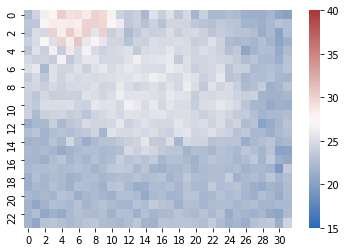

In [94]:
sns.heatmap(data[223,:,:,9] , cmap="vlag" , vmin=15 ,vmax=40)

In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import scipy.stats as sc

In [3]:
def gaussian_pdf(x , sigma , mu):
    pdf1 = (1/(sigma*np.sqrt(2*np.pi)))
    pdf2 = np.exp(-0.5*((x-mu)/sigma)**2)
    return pdf1*pdf2
n = 0.0
mean = np.zeros((235,24,32,16))
mean[0,:,:,0] = np.copy(data[0,:,:,0])
sigma = 0.4
alpha = 0.0001
M = 0
gmean = np.zeros((235,24,32,16))
gp = np.zeros((235,24,32,16))
event = np.zeros((235,24,32,16))

for i in range(0,1):
    for j in range(0,1):
        for k in range(0,24):
            for l in range(0,32):
                event[i,k,l,j] = 1

for j in range(0,16):
    mean[0,:,:,0] = mean[0,:,:,0] + data[0,:,:,j]
for j in range(0,9):
    mean[0,:,:,0] = mean[0,:,:,0] + data[1,:,:,j]

mean[0,:,:,0] = mean[0,:,:,0]/25

fg = []
cnt = np.zeros((236,16))
bg = []
maxi = np.zeros((235,24,32,16))
mini = np.zeros((235,24,32,16))
mini[0,:,:,0] = data[0,:,:,0]
maxi[0,:,:,0] = data[0,:,:,0]
theta = 0.015
gamma = 0.2

In [4]:

for l in range(0,235):
    start = 0
    if l == 0:
        start = 1
    for k in range(start,16):
        for i in range(0,24):
            for j in range(0,32):
                if k==0:
                    mean[l,i,j,k] = alpha*data[l,i,j,k] + mean[l-1,i,j,15]*(1-alpha)        ## Mean if k==0 and l!=0
                    maxi[l,i,j,k] = max(maxi[l-1,i,j,15] , data[l,i,j,k])
                    mini[l,i,j,k] = min(mini[l-1,i,j,15] , data[l,i,j,k])
                else:
                    mean[l,i,j,k] = alpha*data[l,i,j,k] + mean[l,i,j,k-1]*(1-alpha)                  ## Mean if k!=0 and l!=0
                    maxi[l,i,j,k] = max(maxi[l,i,j,k-1] , data[l,i,j,k])
                    mini[l,i,j,k] = min(mini[l,i,j,k-1] , data[l,i,j,k])

                gp[l,i,j,k] = gaussian_pdf(data[l,i,j,k] , sigma , mean[l,i,j,k])                    ## Find the gaussian PDF 
                if gp[l,i,j,k]<n and data[l,i,j,k]>mean[0,i,j,0]:                                   ## Process is foreground
                    event[l,i,j,k] = 0
                    fg.append((data[l,i,j,k] , mean[l,i,j,k]))
                    if k!=0:
                        mean[l,i,j,k] = mean[l,i,j,k-1]                                       ## Update the mean if the process is foreground
                    else:
                        mean[l,i,j,k] = mean[l-1,i,j,15]

                else:
                    event[l,i,j,k] = 1   
                    bg.append((data[l,i,j,k] , mean[l,i,j,k]))                              ## Process is Background

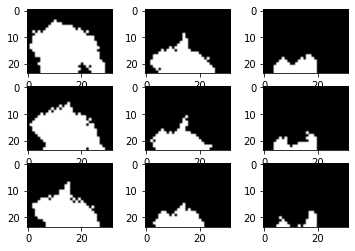

In [24]:
fig, axs = plt.subplots(3, 3)
axs[0,0].imshow(mrf_event[173,:,:,11] , cmap='Greys')
axs[1,0].imshow(mrf_event[152,:,:,12] , cmap='Greys')
axs[2,0].imshow(mrf_event[152,:,:,13] , cmap='Greys')
axs[0,1].imshow(mrf_event[152,:,:,14] , cmap='Greys')
axs[1,1].imshow(mrf_event[152,:,:,15] , cmap='Greys')
axs[2,1].imshow(mrf_event[153,:,:,0] , cmap='Greys')
axs[0,2].imshow(mrf_event[153,:,:,1] , cmap='Greys')
axs[1,2].imshow(mrf_event[153,:,:,2] , cmap='Greys')
axs[2,2].imshow(mrf_event[153,:,:,3] , cmap='Greys')

In [5]:
# Eradicate uncessesary foreground pixels by using the Markov Random Field model

diff = np.zeros((235,24,32,16))
mrf_event = np.zeros((235,24,32,16))
mrf_event[0,:,:,0] = 1
for l in range(0,235):
    for k in range(0,16):
        for i in range(0,24):
            for j in range(0,32):
                qf = 0
                qb = 0
                ratio = gp[l,i,j,k]*25      
                if i>0 and j>0:
                    if event[l,i-1,j-1,k] == 0:
                        qf = qf + 1
                    else:
                        qb = qb + 1
                if i>0:
                    if event[l,i-1,j,k] == 0:
                        qf = qf+1
                    else:
                        qb = qb+1
                if j<31 and i>0:
                    if event[l,i-1,j+1,k] == 0:
                        qf = qf + 1
                    else:
                        qb = qb + 1
                if j>0:
                    if event[l,i,j-1,k] == 0:
                        qf = qf + 1
                    else:
                        qb = qb + 1
                if j<31:
                    if event[l,i,j+1,k] == 0:
                        qf = qf + 1
                    else:
                        qb = qb + 1
                if i<23 and j>0:
                    if event[l,i+1,j-1,k] == 0:
                        qf = qf + 1
                    else:
                        qb = qb + 1
                if i<23:
                    if event[l,i+1,j,k] == 0:
                        qf = qf + 1
                    else:
                        qb = qb + 1
                if i<23 and j<31:
                    if event[l,i+1,j+1,k] == 0:
                        qf = qf + 1
                    else:
                        qb = qb + 1

                mrf = theta * np.exp((qf-qb)/gamma)
                if ratio < mrf and data[l,i,j,k] > mean[l,i,j,k] and data[l,i,j,k] > mean[0,i,j,0]:
                    mrf_event[l,i,j,k] = 0
                    cnt[l,k] = cnt[l,k] + 1
                else:
                    mrf_event[l,i,j,k] = 1
                diff[l,i,j,k] = ratio-mrf


In [97]:
for l in range(0,235):
    for k in range(0,16):
        if cnt[l,k] > 700:
            print(l,k)


In [144]:
cnt[223,9]

302.0

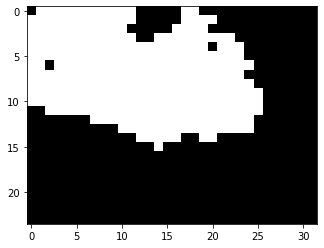

In [93]:
plt.imshow(mrf_event[223,:,:,9] , cmap='Greys')

In [142]:
# Blob detection
# Use Recursive Blob Detection method (Similar to DBSCAN)
def blob_detector(i, j, visited, color=1, second=223, frame=9):
    '''
    Given a frame after BS, detects "blobs"
    '''
    blob_size = 1
    if visited[i,j] != 0 or mrf_event[second,i,j,frame] == 1:
        return 0
    
    visited[i,j] = color
    if i>0 and j>0 and mrf_event[second,i-1,j-1,frame] == 0:
        blob_size = blob_size + blob_detector(i-1,j-1,visited)
        
    if i>0 and mrf_event[second,i-1,j,frame] == 0:
        blob_size = blob_size + blob_detector(i-1,j,visited)
       
    if j<31 and i>0 and mrf_event[second,i-1,j+1,frame] == 0:
        blob_size = blob_size + blob_detector(i-1,j+1,visited)
       
    if j>0 and mrf_event[second,i,j-1,frame] == 0:
        blob_size = blob_size + blob_detector(i,j-1,visited)
       
    if j<31 and mrf_event[second,i,j+1,frame] == 0:
        blob_size = blob_size + blob_detector(i,j+1,visited)
        
    if i<23 and j>0 and mrf_event[second,i+1,j-1,frame] == 0:
        blob_size = blob_size + blob_detector(i+1,j-1,visited)
       
    if i<23 and mrf_event[second,i+1,j,frame] == 0:
        blob_size = blob_size + blob_detector(i+1,j,visited)
       
    if i<23 and j<31 and mrf_event[second,i+1,j+1,frame] == 0:
        blob_size = blob_size + blob_detector(i+1,j+1,visited)
       
    return blob_size

visited = np.zeros((24,32))
blobs = []
blob_detector(0,1,visited)




302